<a href="https://colab.research.google.com/github/sfatimazahra/AI-Headshot-Generator/blob/master/models_sd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

A comparison of Playground v2.5 with other base models for image generation

In [3]:
!pip install -q huggingface_hub==0.16.4
!pip install -q omegaconf==2.3.0
!pip install safetensors
!pip install -U diffusers
!pip install transformers
!pip install accelerate
!pip install sentencepiece
!pip install protobuf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 6.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
accelerate 0.34.2 requires huggingface-hub>=0.21.0, but you have huggingface-hub 0.16.4 which is incompatible.
transformers 4.44.2 requires huggingface-hub<1.0,>=0.23.2, but you have huggingface-hub 0.16.4 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 35.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 436.4/436.4 kB 26.5 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.16.4
    Uninstalling huggingface-hub-0.16.4:
      Successfully u

In [4]:
# !pip install git+https://github.com/huggingface/diffusers
import transformers

import sys
import os
import shutil
import time

import torch
import matplotlib.pyplot as plt
import numpy as np
import safetensors

from PIL import Image

if torch.cuda.is_available():
    device_name = torch.device("cuda")
    torch_dtype = torch.float16
else:
    device_name = torch.device("cpu")
    torch_dtype = torch.float32

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def plotgrid(list_images, list_titles, rows, cols, grid, figname, figsize=(10, 10)):
    num_images  = len(list_images)
    num_cols    = cols
    num_rows    = rows

    # Create a grid of subplots.
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    # ax[rows,cols]
    if isinstance(axes, np.ndarray):
        list_axes = list(axes.flat)
    else:
        list_axes = [axes]

    # Create list of axes for easy iteration.
    for i in range(num_images):
          img    = list_images[i]
          title  = list_titles[i] if list_titles is not None else 'Image %d' % (i)
          list_axes[i].imshow(img)
          list_axes[i].set_title(title)
          list_axes[i].grid(grid)

    for i in range(num_images, len(list_axes)):
        list_axes[i].set_visible(False)

    fig.tight_layout()
    _ = plt.show()

    plt.savefig(figname) if figname is not None else 'Untitled'

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 11 files:   0%|          | 0/11 [00:00<?, ?it/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/796 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

model_index.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/520 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/724 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/756 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.87k [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
Some weights of the model checkpoint were not used when initializing CLIPTextModel: 
 ['text_model.embeddings.position_ids']
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://githu

  0%|          | 0/50 [00:00<?, ?it/s]

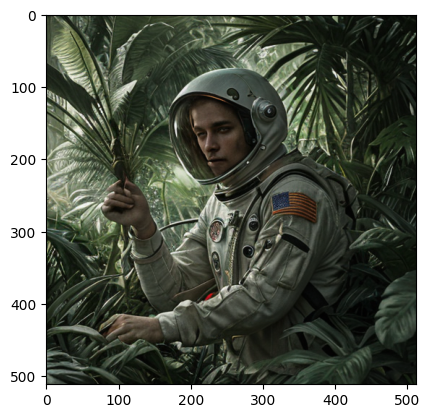

In [ ]:
from diffusers import StableDiffusionPipeline
pipe = StableDiffusionPipeline.from_single_file("/content/drive/MyDrive/Devsort/AI Headshots/models/realDream_15SD15.safetensors", use_safetensors=True)
prompt = "Astronaut in a jungle, cold color palette, muted colors, detailed, 8k"
image = pipe(prompt=prompt, num_inference_steps=50, guidance_scale=3).images[0]
plt.imshow(image)


thru direct model

In [ ]:
from diffusers import DiffusionPipeline
import torch

pipe = DiffusionPipeline.from_pretrained(
    "playgroundai/playground-v2.5-1024px-aesthetic",
    torch_dtype=torch.float16,
    variant="fp16",
).to("cuda")

# # Optional: Use DPM++ 2M Karras scheduler for crisper fine details
# from diffusers import EDMDPMSolverMultistepScheduler
# pipe.scheduler = EDMDPMSolverMultistepScheduler()

prompt = "Astronaut in a jungle, cold color palette, muted colors, detailed, 8k"
image = pipe(prompt=prompt, num_inference_steps=50, guidance_scale=3).images[0]


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

Fetching 18 files:   0%|          | 0/18 [00:00<?, ?it/s]

model.fp16.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/560 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

text_encoder_2/config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/497 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/586 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/704 [00:00<?, ?B/s]

tokenizer_2/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer_2/tokenizer_config.json:   0%|          | 0.00/855 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.78k [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/5.14G [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/746 [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
# Set a random seed
generator = torch.manual_seed(0)
prompt = "a photograph of an astronaut riding a bicycle"
negative_prompt = "disfigured, ugly, bad, low quality"
image = pipe(prompt, negative_prompt=negative_prompt, num_inference_steps=50, guidance_scale=7, generator= generator).images[0]
plt.imshow(image)



**Task 2
Comparing Black Forest Labs FLUX1.dev and FLUX1.schnell**

In [5]:
import time
def calctime(start_time):
  end_time = time.time()
  inference_time = end_time - start_time
  print("Inference time:", inference_time, "seconds")


In [6]:
prompt = [
    "A playful, golden retriever puppy wearing a miniature, orange bowtie suit, smiling at the camera, tongue out, head tilted to one side.",
]
height, width = 1024, 1024
generator = torch.Generator(device="cuda").manual_seed(30)


In [4]:
# FLUX.1 SCHNELL, timestep distilled

from diffusers import FluxPipeline
import torch

ckpt_id = "black-forest-labs/FLUX.1-schnell"
start_time = time.time()
# denoising
pipe = FluxPipeline.from_pretrained(
    ckpt_id,
    torch_dtype=torch.bfloat16,
)
pipe.vae.enable_tiling()
pipe.vae.enable_slicing()
pipe.enable_sequential_cpu_offload() # offloads modules to CPU on a submodule level (rather than model level)

# image = pipe(
#     prompt,
#     num_inference_steps=10,
#     max_sequence_length=256,
#     guidance_scale=0.0,
#     height=height,
#     width=width,
#     generator = generator,
# ).images[0]
# print('Max mem allocated (GB) while denoising:', torch.cuda.max_memory_allocated() / (1024 ** 3))

# plt.imshow(image)
# plt.show()
# calctime(start_time)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:90: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/536 [00:00<?, ?B/s]

Fetching 23 files:   0%|          | 0/23 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.53G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

text_encoder_2/config.json:   0%|          | 0.00/782 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/274 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

(…)t_encoder_2/model.safetensors.index.json:   0%|          | 0.00/19.9k [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/588 [00:00<?, ?B/s]

tokenizer_2/special_tokens_map.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/705 [00:00<?, ?B/s]

tokenizer_2/tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

(…)pytorch_model-00001-of-00003.safetensors:   0%|          | 0.00/9.96G [00:00<?, ?B/s]

(…)pytorch_model-00002-of-00003.safetensors:   0%|          | 0.00/9.95G [00:00<?, ?B/s]

tokenizer_2/tokenizer_config.json:   0%|          | 0.00/20.8k [00:00<?, ?B/s]

transformer/config.json:   0%|          | 0.00/321 [00:00<?, ?B/s]

(…)pytorch_model-00003-of-00003.safetensors:   0%|          | 0.00/3.87G [00:00<?, ?B/s]

(…)ion_pytorch_model.safetensors.index.json:   0%|          | 0.00/121k [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/774 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/168M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


  0%|          | 0/4 [00:00<?, ?it/s]

Max mem allocated (GB) while denoising: 5.886991500854492


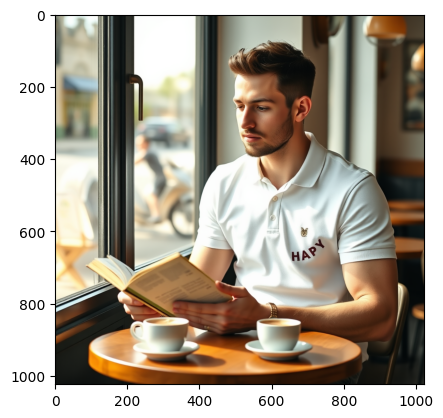

In [8]:

prompt = ('A man in his mid 20s, no beard, caucassian, reading a book, in a well lit cafe during the day, sitting by the window, wearing a white polo shirt titled HAPPY, casual trousers, round table, wooden furniture, with a coffee cup in front of him, having a thoughtful expression.')
image = pipe(
    prompt,
    num_inference_steps=4,
    max_sequence_length=256,
    height=height,
    width=width,
    generator = generator,
).images[0]
print('Max mem allocated (GB) while denoising:', torch.cuda.max_memory_allocated() / (1024 ** 3))

plt.imshow(image)
plt.show()

In [7]:
# FLUX.1 DEV, guidance distilled

from diffusers import FluxPipeline
import torch
from huggingface_hub import login

ckpt_id = "black-forest-labs/FLUX.1-dev"
# prompt = [
#    "A playful, golden retriever puppy wearing a miniature, orange bowtie suit, smiling at the camera, tongue out, head tilted to one side.",
# ]

start_time = time.time()
# denoising


pipe = FluxPipeline.from_pretrained(
    ckpt_id,
    torch_dtype=torch.bfloat16,
)
pipe.vae.enable_tiling()
pipe.vae.enable_slicing()
pipe.enable_sequential_cpu_offload() # offloads modules to CPU on a submodule level (rather than model level)

# image = pipe(
#     prompt,
#     num_inference_steps=20,
#     max_sequence_length=256,
#     guidance_scale=5,
#     height=height,
#     width=width,
#     generator = generator,
# ).images[0]
# print('Max mem allocated (GB) while denoising:', torch.cuda.max_memory_allocated() / (1024 ** 3))

# plt.imshow(image)
# plt.show()
# calctime(start_time)

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /root/.cache/huggingface/token
Login successful


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:90: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/536 [00:00<?, ?B/s]

Fetching 23 files:   0%|          | 0/23 [00:00<?, ?it/s]

text_encoder/config.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/273 [00:00<?, ?B/s]

text_encoder_2/config.json:   0%|          | 0.00/782 [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.53G [00:00<?, ?B/s]

(…)t_encoder_2/model.safetensors.index.json:   0%|          | 0.00/19.9k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/705 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/588 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer_2/special_tokens_map.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer_2/tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

tokenizer_2/tokenizer_config.json:   0%|          | 0.00/20.8k [00:00<?, ?B/s]

transformer/config.json:   0%|          | 0.00/378 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

(…)pytorch_model-00001-of-00003.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

(…)pytorch_model-00002-of-00003.safetensors:   0%|          | 0.00/9.95G [00:00<?, ?B/s]

(…)pytorch_model-00003-of-00003.safetensors:   0%|          | 0.00/3.87G [00:00<?, ?B/s]

(…)ion_pytorch_model.safetensors.index.json:   0%|          | 0.00/121k [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/820 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/168M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
prompt = ('A man in his mid 20s, no beard, caucassian, reading a book, in a well lit cafe during the day, sitting by the window, wearing a white polo shirt titled HAPPY, casual trousers, round table, wooden furniture, with a coffee cup in front of him, having a thoughtful expression.')
image = pipe(
    prompt,
    num_inference_steps=50,
    max_sequence_length=256,
    height=height,
    width=width,
    generator = generator,
).images[0]
print('Max mem allocated (GB) while denoising:', torch.cuda.max_memory_allocated() / (1024 ** 3))

plt.imshow(image)
plt.show()

  0%|          | 0/50 [00:00<?, ?it/s]

Applying LORAs to test different styles

In [ ]:
# SCHNELL
import torch
from pipelines import DiffusionPipeline

base_model = "black-forest-labs/FLUX.1-schnell"
pipe = DiffusionPipeline.from_pretrained(base_model, torch_dtype=torch.bfloat16)
pipe.vae.enable_tiling()
pipe.vae.enable_slicing()
pipe.enable_sequential_cpu_offload()
prompt = ('Photograph, face, realistic, young man in his mid 20s, no beard, caucassian, reading a book, in a well lit cafe during the day, sitting by the window, wearing a white polo shirt titled HAPPY, casual trousers, round table, wooden furniture, with a coffee cup in front of him, having a thoughtful expression.')


In [ ]:
#Canopus-LoRA-Flux-FaceRealism"
pipe.load_lora_weights("prithivMLmods/Canopus-LoRA-Flux-FaceRealism")
image = pipe(
    prompt,
    sampler = 'euler',
    generator = generator,
).images[0]
print('Max mem allocated (GB) while denoising:', torch.cuda.max_memory_allocated() / (1024 ** 3))

plt.imshow(image)
plt.show()


In [ ]:
# yearbook-photo-flux-schnell
pipe.load_lora_weights("ostris/yearbook-photo-flux-schnell")
image = pipe(
    prompt,
    generator = generator,
).images[0]
print('Max mem allocated (GB) while denoising:', torch.cuda.max_memory_allocated() / (1024 ** 3))

plt.imshow(image)
plt.show()

In [ ]:
# historic_color_schnell
pipe.load_lora_weights("AlekseyCalvin/historic_color_schnell", weight_name='HST_Color_Schnell.safetensors')

prompt=("hst style photograph, man in his mid 20s, no beard, caucassian, reading a book, in a well lit cafe during the day, sitting by the window, wearing a white polo shirt titled HAPPY, casual trousers, round table, wooden furniture, with a coffee cup in front of him, having a thoughtful expression.")
image = pipe(
    prompt,
    generator = generator,
).images[0]
print('Max mem allocated (GB) while denoising:', torch.cuda.max_memory_allocated() / (1024 ** 3))

plt.imshow(image)
plt.show()

FLUX DEV

In [ ]:
base_model = "black-forest-labs/FLUX.1-dev"
pipe = DiffusionPipeline.from_pretrained(base_model, torch_dtype=torch.bfloat16)
pipe.vae.enable_tiling()
pipe.vae.enable_slicing()
pipe.enable_sequential_cpu_offload()
prompt=("Photograph, face, young man professional model, minimalist, stylish nessy long hairstyle, beard, profound gaze, Canon EOS R5 with an RF 85mm F1.2L lens, solid white environment, studio lights setting, ultra-realistic, 32K UHD --ar 9:16 --style raw --stylize 700")


In [ ]:
# flux-RealismLora
pipe.load_lora_weights("XLabs-AI/flux-RealismLora")
image = pipe(
    prompt,
    generator = generator,
).images[0]
print('Max mem allocated (GB) while denoising:', torch.cuda.max_memory_allocated() / (1024 ** 3))

plt.imshow(image)
plt.show()

In [ ]:
# Hyper-SD
pipe.load_lora_weights("ByteDance/Hyper-SD")
image = pipe(
    prompt,
    generator = generator,
).images[0]
print('Max mem allocated (GB) while denoising:', torch.cuda.max_memory_allocated() / (1024 ** 3))

plt.imshow(image)
plt.show()

In [ ]:
# flux_film_foto
pipe.load_lora_weights("alvdansen/flux_film_foto")
prompt=("flmft photo style, photograph, face, young man professional model, minimalist, stylish nessy long hairstyle, beard, profound gaze, Canon EOS R5 with an RF 85mm F1.2L lens, solid white environment, studio lights setting, ultra-realistic, 32K UHD --ar 9:16 --style raw --stylize 700")

image = pipe(
    prompt,
    generator = generator,
).images[0]
print('Max mem allocated (GB) while denoising:', torch.cuda.max_memory_allocated() / (1024 ** 3))

plt.imshow(image)
plt.show()

In [ ]:
# flux-tarot-v1
pipe.load_lora_weights("multimodalart/flux-tarot-v1")
prompt=("In the style of TOK a trtcrd, tarot style, photograph, face, young man professional model, minimalist, stylish nessy long hairstyle, beard, profound gaze, Canon EOS R5 with an RF 85mm F1.2L lens, solid white environment, studio lights setting, ultra-realistic, 32K UHD --ar 9:16 --style raw --stylize 700")
image = pipe(
    prompt,
    generator = generator,
).images[0]
print('Max mem allocated (GB) while denoising:', torch.cuda.max_memory_allocated() / (1024 ** 3))

plt.imshow(image)
plt.show()